Image shape: (420, 265, 3)
Yellow trap area: 110796 pixels

Total contours found: 307

ACCURATE PEST COUNT ANALYSIS

Total insects detected: 178

Size Classification:
  Small insects:  163 (area < 200 pixels²)
  Medium insects: 15 (area 200-1000 pixels²)
  Large insects:  0 (area > 1000 pixels²)
accurate_pest_analysis.png
accurate_pest_report.json
accurate_pest_summary.txt

Analysis complete!


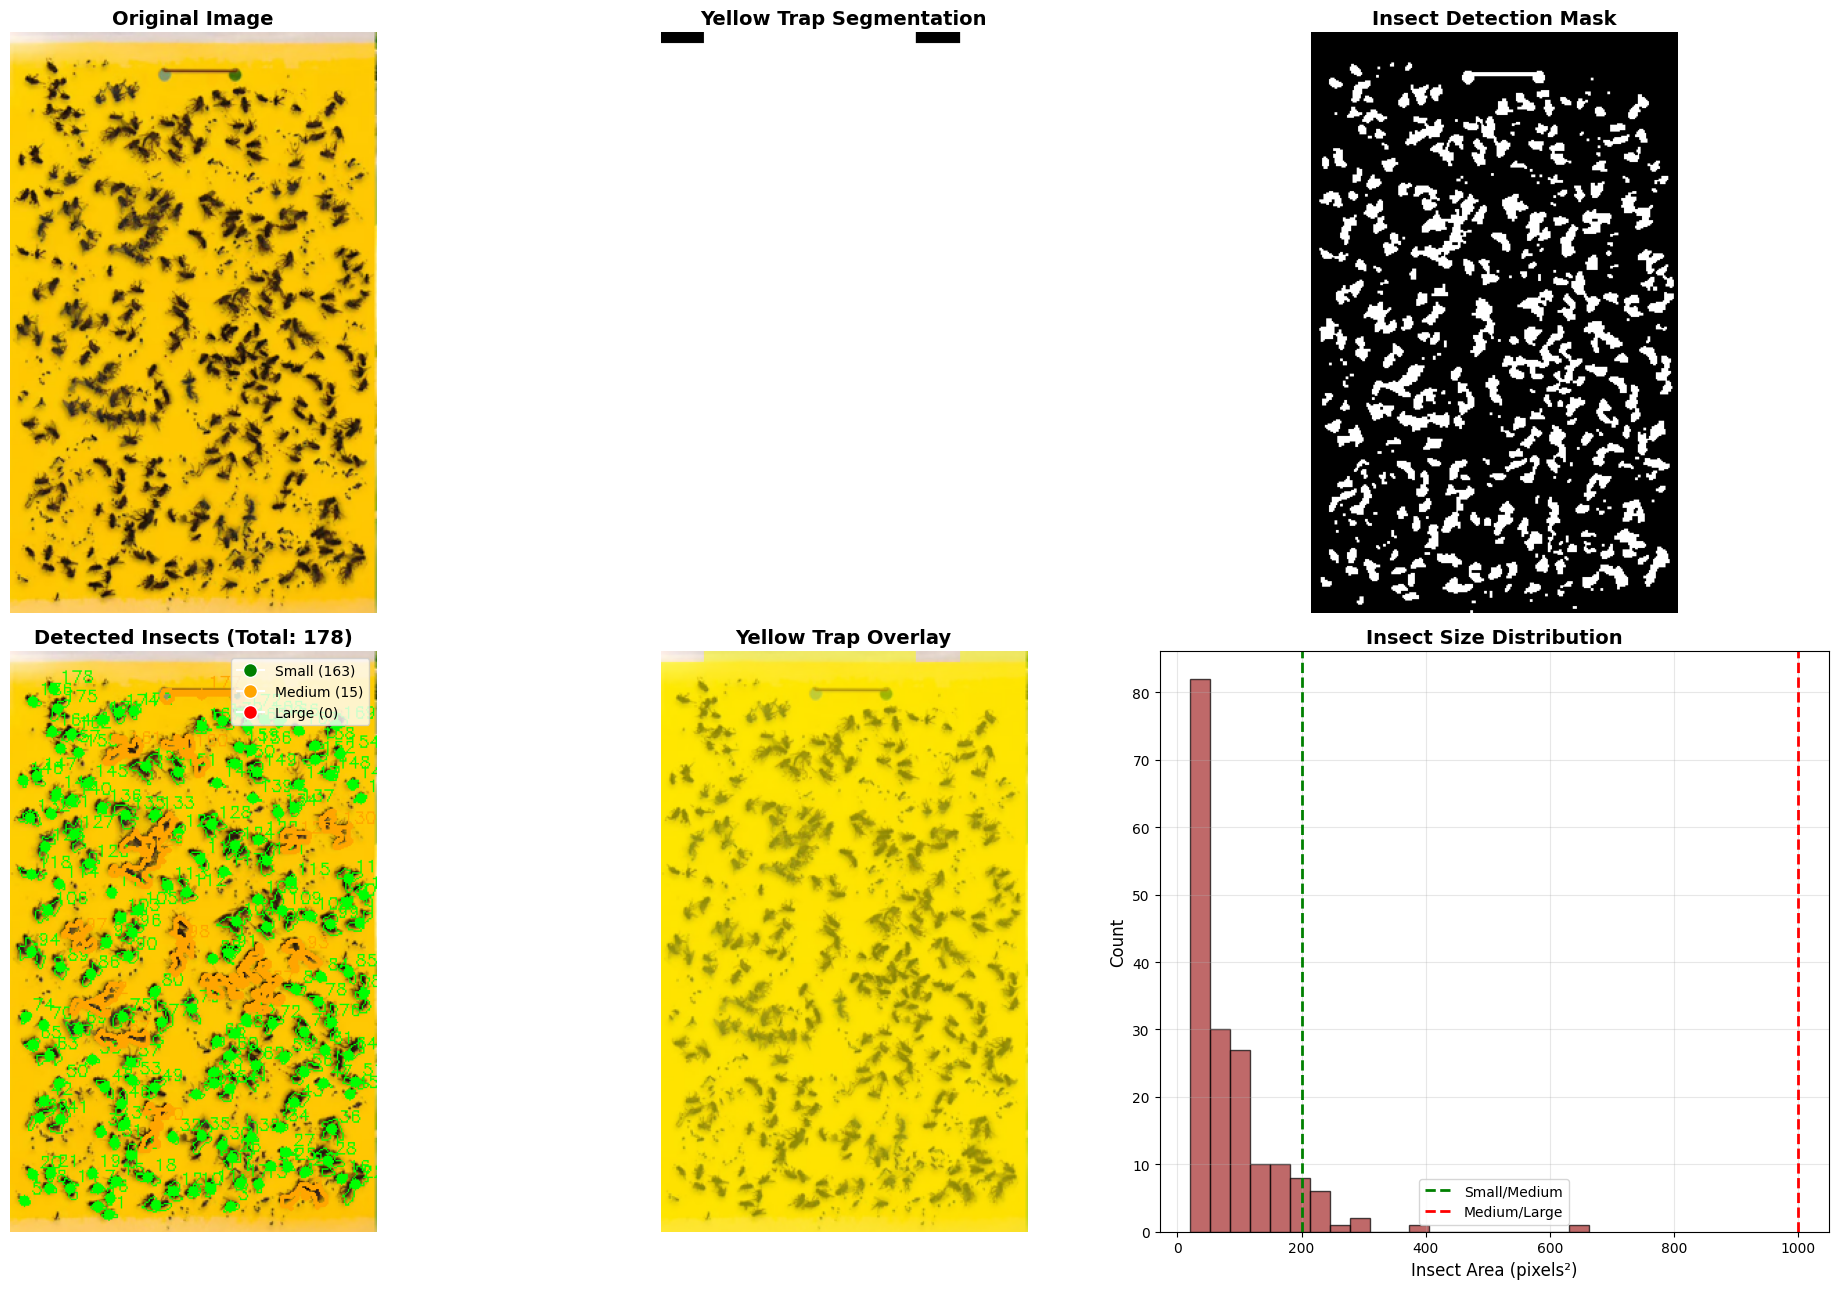

In [8]:
import cv2
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import json

# Load the image
img_path = 'trap5.png'
img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Create a copy for visualization
img_annotated = img_rgb.copy()

print("Image shape:", img.shape)

# Convert to HSV for better color segmentation
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# Step 1: ACCURATELY segment ONLY the yellow sticky trap
# Fine-tuned yellow range for sticky trap
lower_yellow = np.array([15, 80, 120])
upper_yellow = np.array([35, 255, 255])

# Create mask for yellow regions
yellow_mask = cv2.inRange(hsv, lower_yellow, upper_yellow)

# Clean up the yellow mask - remove small noise
kernel_large = np.ones((15,15), np.uint8)
yellow_mask = cv2.morphologyEx(yellow_mask, cv2.MORPH_CLOSE, kernel_large)
yellow_mask = cv2.morphologyEx(yellow_mask, cv2.MORPH_OPEN, kernel_large)

# Fill holes in the yellow mask
contours_yellow, _ = cv2.findContours(yellow_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
yellow_mask_filled = np.zeros_like(yellow_mask)

# Keep only the largest yellow region (the trap itself)
if len(contours_yellow) > 0:
    largest_contour = max(contours_yellow, key=cv2.contourArea)
    cv2.drawContours(yellow_mask_filled, [largest_contour], -1, 255, -1)
    yellow_mask = yellow_mask_filled

print(f"Yellow trap area: {np.sum(yellow_mask > 0)} pixels")

# Step 2: Create a region of interest (ROI) - ONLY the yellow trap
roi_mask = yellow_mask.copy()

# Step 3: Detect dark insects ONLY within the yellow trap
# Convert to LAB color space for better insect detection
lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
l_channel, a_channel, b_channel = cv2.split(lab)

# Insects appear dark on the yellow background
# Use adaptive thresholding on the L channel within the yellow region
l_channel_roi = cv2.bitwise_and(l_channel, l_channel, mask=yellow_mask)

# Apply adaptive threshold to find dark spots
insects_mask = cv2.adaptiveThreshold(
    l_channel_roi,
    255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY_INV,
    51,  # Block size
    15   # C constant
)

# Only keep detections within the yellow trap
insects_mask = cv2.bitwise_and(insects_mask, yellow_mask)

# Alternative method: Direct dark detection in HSV
hsv_roi = cv2.bitwise_and(hsv, hsv, mask=yellow_mask)

# Detect dark/brown insects (low value in HSV)
lower_insect = np.array([0, 0, 0])
upper_insect = np.array([180, 255, 100])  # Dark objects
dark_mask = cv2.inRange(hsv, lower_insect, upper_insect)
dark_mask = cv2.bitwise_and(dark_mask, yellow_mask)

# Combine both detection methods
insects_mask = cv2.bitwise_or(insects_mask, dark_mask)

# Step 4: Filter out white petals and other non-insects
# White regions have high value and low saturation
lower_white = np.array([0, 0, 180])
upper_white = np.array([180, 50, 255])
white_mask = cv2.inRange(hsv, lower_white, upper_white)

# Remove white regions from insect detections
insects_mask = cv2.bitwise_and(insects_mask, cv2.bitwise_not(white_mask))

# Clean up the insect mask
kernel_small = np.ones((2,2), np.uint8)
insects_mask = cv2.morphologyEx(insects_mask, cv2.MORPH_OPEN, kernel_small)
insects_mask = cv2.morphologyEx(insects_mask, cv2.MORPH_CLOSE, kernel_small)

# Step 5: Find contours of insects
contours, _ = cv2.findContours(insects_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filter and classify insects by size
insects_data = []
small_insects = []
medium_insects = []
large_insects = []

# Size thresholds (adjusted for actual insects)
MIN_INSECT_AREA = 20  # Minimum area to be considered an insect
SMALL_THRESHOLD = 200
MEDIUM_THRESHOLD = 1000

print(f"\nTotal contours found: {len(contours)}")

for idx, contour in enumerate(contours):
    area = cv2.contourArea(contour)
    
    # Filter out very small noise and very large objects (not insects)
    if area < MIN_INSECT_AREA or area > 15000:
        continue
    
    # Get bounding rectangle
    x, y, w, h = cv2.boundingRect(contour)
    
    # Additional filter: Check aspect ratio (insects have reasonable proportions)
    aspect_ratio = max(w, h) / min(w, h) if min(w, h) > 0 else 0
    if aspect_ratio > 10:  # Too elongated, likely noise
        continue
    
    # Calculate centroid
    M = cv2.moments(contour)
    if M["m00"] != 0:
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
    else:
        cx, cy = x + w//2, y + h//2
    
    # Verify the centroid is within the yellow trap
    if yellow_mask[cy, cx] == 0:
        continue
    
    insect_info = {
        'id': len(insects_data) + 1,
        'area': area,
        'position': (cx, cy),
        'bbox': (x, y, w, h),
        'perimeter': cv2.arcLength(contour, True),
        'aspect_ratio': aspect_ratio
    }
    
    # Classify by size
    if area < SMALL_THRESHOLD:
        insect_info['size_class'] = 'Small'
        small_insects.append(insect_info)
        color = (0, 255, 0)  # Green for small
        thickness = 1
    elif area < MEDIUM_THRESHOLD:
        insect_info['size_class'] = 'Medium'
        medium_insects.append(insect_info)
        color = (255, 165, 0)  # Orange for medium
        thickness = 2
    else:
        insect_info['size_class'] = 'Large'
        large_insects.append(insect_info)
        color = (255, 0, 0)  # Red for large
        thickness = 2
    
    insects_data.append(insect_info)
    
    # Draw on annotated image
    cv2.drawContours(img_annotated, [contour], -1, color, thickness)
    cv2.circle(img_annotated, (cx, cy), 4, color, -1)
    # Draw ID number
    cv2.putText(img_annotated, str(insect_info['id']), (cx+5, cy-5), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.4, color, 1)

# Print results
print("\n" + "="*60)
print("ACCURATE PEST COUNT ANALYSIS")
print("="*60)
print(f"\nTotal insects detected: {len(insects_data)}")
print(f"\nSize Classification:")
print(f"  Small insects:  {len(small_insects)} (area < {SMALL_THRESHOLD} pixels²)")
print(f"  Medium insects: {len(medium_insects)} (area {SMALL_THRESHOLD}-{MEDIUM_THRESHOLD} pixels²)")
print(f"  Large insects:  {len(large_insects)} (area > {MEDIUM_THRESHOLD} pixels²)")
print("="*60)

# Create visualization
fig, axes = plt.subplots(2, 3, figsize=(20, 13))

# Original image
axes[0, 0].imshow(img_rgb)
axes[0, 0].set_title('Original Image', fontsize=14, fontweight='bold')
axes[0, 0].axis('off')

# Yellow trap mask
axes[0, 1].imshow(yellow_mask, cmap='gray')
axes[0, 1].set_title('Yellow Trap Segmentation', fontsize=14, fontweight='bold')
axes[0, 1].axis('off')

# Insect detection mask
axes[0, 2].imshow(insects_mask, cmap='gray')
axes[0, 2].set_title('Insect Detection Mask', fontsize=14, fontweight='bold')
axes[0, 2].axis('off')

# Annotated image with detections
axes[1, 0].imshow(img_annotated)
axes[1, 0].set_title(f'Detected Insects (Total: {len(insects_data)})', fontsize=14, fontweight='bold')
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label=f'Small ({len(small_insects)})'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=10, label=f'Medium ({len(medium_insects)})'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label=f'Large ({len(large_insects)})')
]
axes[1, 0].legend(handles=legend_elements, loc='upper right')
axes[1, 0].axis('off')

# Overlay of yellow trap on original
overlay = img_rgb.copy()
overlay[yellow_mask > 0] = overlay[yellow_mask > 0] * 0.5 + np.array([255, 255, 0]) * 0.5
axes[1, 1].imshow(overlay.astype(np.uint8))
axes[1, 1].set_title('Yellow Trap Overlay', fontsize=14, fontweight='bold')
axes[1, 1].axis('off')

# Size distribution
if len(insects_data) > 0:
    sizes = [p['area'] for p in insects_data]
    axes[1, 2].hist(sizes, bins=20, color='brown', alpha=0.7, edgecolor='black')
    axes[1, 2].axvline(SMALL_THRESHOLD, color='green', linestyle='--', linewidth=2, label='Small/Medium')
    axes[1, 2].axvline(MEDIUM_THRESHOLD, color='red', linestyle='--', linewidth=2, label='Medium/Large')
    axes[1, 2].set_xlabel('Insect Area (pixels²)', fontsize=12)
    axes[1, 2].set_ylabel('Count', fontsize=12)
    axes[1, 2].set_title('Insect Size Distribution', fontsize=14, fontweight='bold')
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)
else:
    axes[1, 2].text(0.5, 0.5, 'No insects detected', ha='center', va='center', fontsize=14)
    axes[1, 2].axis('off')

plt.tight_layout()
plt.savefig('accurate_pest_analysis.png', dpi=300, bbox_inches='tight')
print(f"accurate_pest_analysis.png")

# Create detailed report
report = {
    'total_insects': len(insects_data),
    'small_insects': len(small_insects),
    'medium_insects': len(medium_insects),
    'large_insects': len(large_insects),
    'size_thresholds': {
        'min_area': MIN_INSECT_AREA,
        'small_max': SMALL_THRESHOLD,
        'medium_max': MEDIUM_THRESHOLD
    },
    'insect_details': insects_data
}

# Save report as JSON
with open('accurate_pest_report.json', 'w') as f:
    json.dump(report, f, indent=2)

print(f"accurate_pest_report.json")

# Create a summary text file
with open('accurate_pest_summary.txt', 'w') as f:
    f.write("="*60 + "\n")
    f.write("YELLOW STICKY TRAP - ACCURATE PEST COUNT ANALYSIS\n")
    f.write("="*60 + "\n\n")
    f.write(f"Total Insects Detected: {len(insects_data)}\n\n")
    if len(insects_data) > 0:
        f.write("Size Classification:\n")
        f.write(f"  - Small insects:  {len(small_insects)} ({len(small_insects)/len(insects_data)*100:.1f}%)\n")
        f.write(f"  - Medium insects: {len(medium_insects)} ({len(medium_insects)/len(insects_data)*100:.1f}%)\n")
        f.write(f"  - Large insects:  {len(large_insects)} ({len(large_insects)/len(insects_data)*100:.1f}%)\n\n")
        f.write("Size Criteria:\n")
        f.write(f"  - Minimum area: {MIN_INSECT_AREA} pixels²\n")
        f.write(f"  - Small: area < {SMALL_THRESHOLD} pixels²\n")
        f.write(f"  - Medium: area {SMALL_THRESHOLD}-{MEDIUM_THRESHOLD} pixels²\n")
        f.write(f"  - Large: area > {MEDIUM_THRESHOLD} pixels²\n\n")
        f.write("Individual Insect Details:\n")
        f.write("-" * 60 + "\n")
        for insect in insects_data:
            f.write(f"ID: {insect['id']} | Size: {insect['size_class']} | ")
            f.write(f"Area: {insect['area']:.0f} px² | ")
            f.write(f"Position: ({insect['position'][0]}, {insect['position'][1]})\n")
    f.write("="*60 + "\n")

print(f"accurate_pest_summary.txt")
print("\nAnalysis complete!")